In [23]:
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
import d2l.torch as d2l

In [24]:

def dataloader(trainPath: str = "./train.csv", testPath: str = "./test.csv"):
    train_data = pd.read_csv(trainPath)
    test_data = pd.read_csv(testPath)
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))


    numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
    #norm 
    all_features[numeric_features] = all_features[numeric_features].apply(
        lambda x: (x - x.mean())/(x.std()))
    # 
    all_features[numeric_features] = all_features[numeric_features].fillna(0)

    all_features = pd.get_dummies(all_features, dummy_na=True, dtype=float)

    n_train = train_data.shape[0]
    train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
    test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
    train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

    return train_features, test_features, train_labels


In [25]:
def log_rmse(net, loss, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [26]:
def train(net, 
          loss,
          train_features, 
          train_labels, 
          test_features, 
          test_lables, 
          num_epochs, 
          learning_rate,
          weight_decay, 
          batch_size, 
    ):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(*(train_features, train_labels))
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, loss, train_features, train_labels))
        if test_lables is not None:
            test_ls.append(log_rmse(net, loss, test_features, test_lables))
        
    return train_ls, test_ls

In [27]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j==i:
            X_valid,  y_valid = X_part, y_part
        elif X_train is None:
            X_train,  y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
        
    return X_train, y_train, X_valid, y_valid

In [28]:
def k_fold(k, net, loss, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(net, loss, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], 
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs+1],
                     legend=['train, valid'], yscale='log')
        print(f'fold{i+1}, train log rmse {float(train_ls[-1]):f} \n' + 
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum/k, valid_l_sum/k


In [29]:
def pred(net, test_features, test_data):
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [32]:
def get_net(in_features: int):
    net = nn.Sequential(nn.Linear(in_features, 128),
                        nn.LeakyReLU(),
                        nn.Linear(128, 128),
                        nn.LeakyReLU(),
                        nn.Linear(128,1)
                        )
    return net


fold1, train log rmse 0.096811 
valid log rmse 0.156095
fold2, train log rmse 0.070304 
valid log rmse 0.145173
fold3, train log rmse 0.057896 
valid log rmse 0.115330
fold4, train log rmse 0.038671 
valid log rmse 0.097641
fold5, train log rmse 0.016241 
valid log rmse 0.107883


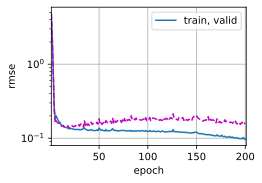

In [33]:

train_features, test_features, train_labels = dataloader()
test_data = pd.read_csv("./test.csv")

loss = nn.MSELoss()
in_features = train_features.shape[1]
net = get_net(in_features)

k, num_epochs, lr, weight_decay, batch_size = 5, 200, 0.01, 0, 64
train_l, valid_l = k_fold(k, net, loss, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
#pred(net, test_features, test_data)